In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') #, force_remount=True

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('gdrive/My Drive/Colab Notebooks/ml_2/DAN')

In [ ]:
!pip install datasets

In [ ]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from datasets import load_dataset
from nltk.tokenize import ToktokTokenizer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

# Deep Average Network для определения сентимента 

В этой домашке мы будет классифицировать твиты на 3 тональности.  
Вы будете использовать предобученные эмбеддинги слов, так что для начала обязательно нужно посмотреть [туториал по их использованию](https://github.com/BobaZooba/DeepNLP/blob/master/Tutorials/Word%20vectors%20%26%20Data%20Loading.ipynb).

Наши классы:  

Индекс | Sentiment  
-- | --  
0 | negative  
1 | neutral  
2 | positive  

Вам предстоит реализовать такую модель:
![Архитектура модели DAN](https://www.researchgate.net/profile/Shervin-Minaee/publication/340523298/figure/fig1/AS:878252264550411@1586403065555/The-architecture-of-the-Deep-Average-Network-DAN-10.ppm)

Что она из себя представляет:
- Мы подаем в нее индексы слов
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`

В этой домашке вам предстоит:
- Перевести тексты в матрицы с индексами токенов
- Реализовать модель
- Обучить ее
- Понять хорошо ли вы это сделали

Это очень важная модель, потому что она очень простая и показывает достаточно высокие метрики. В дальнейшем на работе советую использовать такую модель как бейзлайн. И в качестве эмбеддингов слов взять эмбеддинги от берта/роберты/тд.

## 🤗 Datasets
В этом туториале мы будем использовать подготовленные данные из библиотеки [datasets](https://github.com/huggingface/datasets). Мы вряд ли еще будем пользоваться этой библиотекой, так как нам будет важно самим подготавливать данные. Во-первых, для простоты, во-вторых, здесь есть достаточно неплохие практики. [Здесь](https://huggingface.co/datasets) вы сможете найти достаточно большое количество различных датасетов. Возможно, когда-нибудь они вам пригодятся.

## Загрузите эмбеддинги слов
Реализуйте функцию по загрузке эмбеддингов из файла. Она должна отдавать словарь слов и `np.array`
Формат словаря:
```python
{
    'aabra': 0,
    ...,
    'mom': 6546,
    ...
    'xyz': 100355
}
```
Формат матрицы эмбеддингов:
```python
array([[0.44442278, 0.28644582, 0.04357426, ..., 0.9425766 , 0.02024289,
        0.88456545],
       [0.77599317, 0.35188237, 0.54801261, ..., 0.91134102, 0.88599103,
        0.88068835],
       [0.68071886, 0.29352313, 0.95952505, ..., 0.19127958, 0.97723054,
        0.36294011],
       ...,
       [0.03589378, 0.85429694, 0.33437761, ..., 0.39784873, 0.80368014,
        0.76368042],
       [0.01498725, 0.78155695, 0.80372969, ..., 0.82051826, 0.42314861,
        0.18655465],
       [0.69263802, 0.82090775, 0.27150426, ..., 0.86582747, 0.40896573,
        0.33423976]])
```

Количество строк в матрице эмбеддингов должно совпадать с размером словаря, то есть для каждого токена должен быть свой эмбеддинг. По параметру `num_tokens` должно брать не более указано в этом параметре количество токенов в словарь и матрицу эмбеддингов.

In [ ]:
## Раскомментируйте и скачайте эмбеддинги
#!wget  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
#!gzip -d cc.ru.300.vec.gz

In [ ]:
def load_embeddings(path, num_tokens=100_000):
    """
    Функция возвращает словарь вида "слово:id" и соответствующую матрицу эмбеддингов
    
    """
    vocab = {'<PAD>': 0, '<UNK>': 1}
    embeddings = list()
    
    with open(path, 'r') as emb_file:

      vocab_size, emb_dim = emb_file.readline().strip().split()
      vocab_size = int(vocab_size)
      emb_dim = int(emb_dim)
      
      if num_tokens is None or num_tokens == 0:
        num_tokens = vocab_size + 2 # +2 для учета спец токенов
      
      embeddings.append(np.zeros(emb_dim))
      embeddings.append(np.ones(emb_dim))

      for line in emb_file:
        parts = line.strip().split()
        token = ' '.join(parts[:-emb_dim]).lower()
        if token in vocab:
          continue
        word_vector = np.array(list(map(float, parts[-emb_dim:])))
        vocab[token] = len(vocab)
        embeddings.append(word_vector)
        
        if len(vocab) == num_tokens:
          break
    
    embeddings = np.stack(embeddings)

    return vocab, embeddings

In [ ]:
vocab, embeddings = load_embeddings('cc.ru.300.vec', num_tokens=100000)

## Загружаем данные из библиотеки
Мы сразу получим `torch.utils.data.Dataset`, который сможем передать в `torch.utils.data.DataLoader`

In [ ]:
dataset_path = "tweet_eval"
dataset_name = "sentiment"

train_dataset = load_dataset(path=dataset_path, name=dataset_name, split="train")
valid_dataset = load_dataset(path=dataset_path, name=dataset_name, split="validation")
test_dataset = load_dataset(path=dataset_path, name=dataset_name, split="test")

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.53k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


## `torch.utils.data.DataLoader`

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

## Посмотрим что отдает нам `Loader`
Это батч формата:
```python
batch = {
    "text": [
        "text1",
        "text2",
        ...,
        "textn"
    ],
    "label": tensor([
        1,
        1,
        ...,
        0
    ])
}
```
То есть у нас есть словарь с двумя ключами `text` и `label`, где хранится n примеров. То есть для 5-го примера в батче текст будет храниться в `batch["text"][5]`, а индекс класса будет храниться в `batch["label"][5]`.

In [ ]:
for batch in train_loader:
    break

batch

{'label': tensor([2, 2]),
 'text': ['Can\\u2019t wait to go to to the Patriots game dec. 10th :) ahhh i hope we get a mssive snow storm!',
  '@user would you PLEASE let us know when the iPhone 6s will be available for purchase? Hoping before the 17th of September. Thanks!!']}

## Collate
Сейчас перед нами стоит проблема: мы получаем тексты в виде строк, а нам нужны тензоры (матрицы) с индексами токенов, к тому же нам нужно западить последовательности токенов, чтобы все сложить в торчовую матрицу. Мы можем сделать это двумя способами:
- Достать из `train/valid/test_dataset` данные и написать свой `Dataset`, где внутри будет токенизировать текст, токены будут переводиться в индексы и затем последовательность будет падиться до нужной длины
- Сделать функцию, которая бы дополнительно обрабатывали наши батчи. Она вставляется в `DataLoader(collate_fn=<ВАША_ФУНКЦИЯ>)`

## Если вы хотите сделать свой `Dataset`
То вы можете достать данные таким образом.

In [ ]:
len(train_dataset["text"]), len(train_dataset["label"])

(45615, 45615)

In [ ]:
train_dataset["text"][:2]

['"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"',
 '"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"']

In [ ]:
train_dataset["label"][:2]

[2, 1]

## Если вы хотите сделать `collate_fn`

### Давайте посмотрим что вообще происходит внутри этого метода
Для этого сделаем функцию `empty_collate`, которая принимает на вход батч и отдает его, ничего с ним не делая

In [ ]:
def empty_collate(batch):
    return batch

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=empty_collate)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)

In [ ]:
for batch in train_loader:
    break

batch

[{'label': 0,
  'text': "@user paid for Amazon prime. 2nd day my products hasn't arrived how does your company resolve this...Tells me it will be here tomorrow!"},
 {'label': 2,
  'text': 'Janet jackson is back (and she brought some extra saggy pampers pants with her)'}]

## Формат батча
```python
batch = [
    {
        "text": "text1",
        "label": 0
    }, 
    {
        "text": "text2",
        "label": 1
    },
    ...,
    {
        "text": "textn",
        "label": 1
    }
]
```
То есть теперь у нас есть список, где каждый элемент — это словарь со значениями `text` и `label`.  

Вы можете сделать функцию или класс с методом `collate`. Этот способ решения домашки предодчтительней, так как использовать `collate` очень хорошая практика.

Что я предлагаю:
- Сделайте класс `Tokenizer`

In [ ]:
class Tokenizer:
    
    def __init__(self, base_tokenizer, token2index, pad_token, unk_token, max_length):
        
        self._base_tokenizer = base_tokenizer  # например ToktokTokenizer()
        
        self.token2index = token2index  # словарь из load_embeddings()
        
        self.pad_token = pad_token
        self.pad_index = self.token2index[self.pad_token]
        
        self.unk_token = unk_token
        self.unk_index = self.token2index[self.unk_token]
        
        self.max_length = max_length

    def tokenize(self, text):
        """
        В этом методе нужно разделить строку текста на токены
        """
        return self._base_tokenizer.tokenize(text)
    
    def indexing(self, tokenized_text):
        """
        В этом методе нужно перевести список токенов в список с индексами этих токенов
        """
        token_ids = []
        for token in tokenized_text:
            token_id = self.token2index.get(token, self.unk_index)
            token_ids.append(token_id)

        return token_ids
        
    def padding(self, tokens_indices):
        """
        В этом методе нужно сделать длину tokens_indices равной self.max_length
        Опционально убрать повторяющиеся unk'и
        """
        if len(tokens_indices) > self.max_length:
            return tokens_indices[:self.max_length]
        
        diff = self.max_length - len(tokens_indices)
        padding_idx = [self.pad_index] * diff
        tokens_indices.extend(padding_idx)

        return tokens_indices
    
    def __call__(self, text):
        """
        В этом методе нужно перевести строку с текстом в вектор с индексами слов нужно размера (self.max_length)
        """
        text_tokens = self.tokenize(text)
        text_ids = self.indexing(text_tokens)
        text_padded = self.padding(text_ids)
        
        return text_padded
        
    def collate(self, batch):
        
        tokenized_texts = list()
        labels = list()
        
        for sample in batch:
            label = sample["label"]
            text = sample["text"]
            tokenized_texts.append(self(text))
            labels.append(label)
            
        tokenized_texts = torch.tensor(tokenized_texts)
        labels = torch.tensor(labels)
        
        return tokenized_texts, labels

In [ ]:
tokenizer = Tokenizer(
    base_tokenizer=ToktokTokenizer(),
    token2index=vocab,
    pad_token="<PAD>",
    unk_token="<UNK>",
    max_length=64)

## Перед реализацией выбранного метода
Советую, чтобы в итоге `Loader` отдавал кортеж с двумя тензорами:
- `torch.Tensor` с индексами токенов, размерность `(batch_size, sequence_length)`
- `torch.Tensor` с индексами таргетов, размерность `(batch_size)`

То есть, чтобы было так:
```python
for x, y in train_loader:
    ...

>> x
>> tensor([[   37,  3889,   470,  ...,     0,     0,     0],
           [ 1509,   581,   144,  ...,     0,     0,     0],
           [ 1804,   893,  2457,  ...,     0,     0,     0],
           ...,
           [  170, 39526,  2102,  ...,     0,     0,     0],
           [ 1217,   172, 28440,  ...,     0,     0,     0],
           [   37,    56,   603,  ...,     0,     0,     0]])

>> y
>> tensor([1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1,
           0, 2, 1, 1, 0, 1, 2, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0,
           1, 0, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 0, 1, 0, 2, 1, 2, 2, 1, 0, 0, 2, 2,
           2, 1, 2, 0, 2, 2, 0, 2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 2,
           2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 1,
           2, 1, 1, 2, 2, 1, 1, 2])

>> x.shape
>> torch.Size([128, 64])

>> y.shape
>> torch.Size([128])
```
При условии, что батч сайз равен 128, а максимальная длина последовательности равна 64.

## Помните

## <Место для реализации>

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=tokenizer.collate)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True, collate_fn=tokenizer.collate)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, collate_fn=tokenizer.collate)

In [ ]:
for x, y in train_loader:
  print(x.shape)
  print(y.shape)
  break

torch.Size([128, 64])
torch.Size([128])


In [ ]:
assert(isinstance(x, torch.Tensor))
assert(len(x.size()) == 2)

assert(isinstance(y, torch.Tensor))
assert(len(y.size()) == 1)

# Реализация DAN

На вход модели будут подавать индексы слов

Шаги:
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`
    - Нужно реализовать самому
    
Дополнительно:
- Добавьте `nn.Dropout`, `nn.BatchNorm` по вкусу
- Сделайте усреднение с учетом падов
- Используйте эмбеддинги от берта/роберты/тд (когда-нибудь про это будет целый туториал, а пока предлагают вам попробовать сделать это самим)

# Советы

## До обучения
- Выберите метрику(ки) качества и расскажите почему она(они)
    - Обычно есть основная метрика, по которой принимаем решения какие веса брать и дополнительные, которые нам помогут делать выводы, например, о том все ли хорошо с нашими данными, хорошо ли модель справляется с дисбалансом классов и тд
- Эту домашку можно сделать и на `CPU`, но на `GPU` будет сильно быстрее
    - Во всех остальных домашках мы будем учить модели на `GPU`
    - Рано или поздно вам придется посмотреть этот [туториал](https://www.youtube.com/watch?v=pgk1zGv5lU4)
    - Вы можете обучаться на `colab`, это бесплатно

## До эпохи
- Сделайте списки/словари/другое, чтобы сохранять нужные данные для расчета метрик(и) по всей эпохе для трейна и валидации

## Во время эпохи
- Используйте [`tqdm`](https://github.com/tqdm/tqdm) как прогресс бар, чтобы понимать как проходит ваше обучение
- Логируйте лосс
- Логируйте метрику(ки) по батчу
- Сохраняйте то, что вам нужно, чтобы посчитать метрик(и) на всю эпоху для трейна и валидации

## После эпохи
- Посчитайте метрик(и) на всю эпоху для трейна и валидации

## После обучения
- Провалидируйтесь на тестовом наборе и посмотрите метрики
- Постройте [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- Постройте графики:
    - [Confusion Matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)
    - [Опционально] Распределение вероятностей мажоритарного класса (то есть для какого-то примера мы выбираем такой класс и вероятность этого выбора такая-то) на трейне/тесте/валидации
        - Если класс был выбран верно и если была ошибка
- Подумайте что еще вам будет полезно для того, чтобы ответить на такие вопросы: 
    - Что в моделе можно улучшить?
    - Все ли хорошо с моими данными?
    - Все ли хорошо с валидацией?
    - Не переобучился ли я?
    - Достаточно ли я посмотрел на данные?
    - Нужно ли мне улучшить предобработку данных?
    - Нужно ли поменять токенизацию или эмбеддинги?
    - Нет ли у меня багов в реализации?
    - Какие типичные ошибки у моей модели?
    - Как я могу их исправить?

# Посмотрим на распределение данных в выборках

In [ ]:
train_labels = pd.Series([x["label"] for x in train_dataset])
valid_labels = pd.Series([x["label"] for x in valid_dataset])
test_labels = pd.Series([x["label"] for x in test_dataset])

In [ ]:
labels = [train_labels, valid_labels, test_labels]
id2label = {0: "neg", 1: "neut", 2:"pos"}

titles = ["Train labels distibution", "Validation labels distibution", "Test labels distibution"]

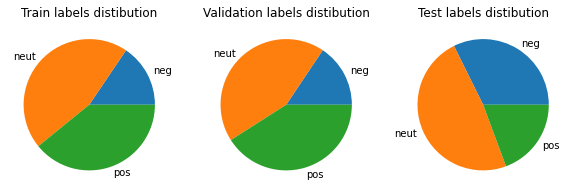

In [ ]:
fig, axis = plt.subplots(1, 3, figsize=(10,10))

for i in range(0,3):
  label, title = labels[i], titles[i]
  label_counts = pd.Series({k:v for k,v in sorted(label.value_counts().items(), key=lambda x: x[0])})
  axis[i].set_title(title, fontsize=12)
  axis[i].pie(
      label_counts,
      labels=[id2label[k] for k in label_counts.keys()], 
      pctdistance=0.5, 
      textprops = {"fontsize": 10},)

# Я выбрала метрику Weighted-F1
Как видно на графиках выше, датасет несбалансированный, а weighted-F1 как раз учитывает дисбаланс классов, вычисляя взвешенное среднее значение для каждого класса с учетом его присутствия в выборке данных.

In [ ]:
class DeepAverageNetwork(nn.Module):
    def __init__(self, vocab_size=100000, embeddings = None, emb_dim=300, hidden_size_1=128, n_classes=3):
      super().__init__()

      self.embeddings = nn.Embedding(vocab_size, emb_dim).from_pretrained(torch.Tensor(embeddings)) 
      self.lin_1 = nn.Linear(emb_dim, hidden_size_1)
      self.bnorm = nn.BatchNorm1d(hidden_size_1)
      self.relu = nn.ReLU()
      self.lin_2 = nn.Linear(hidden_size_1, n_classes)

    def forward(self, x):
        
        x = self.embeddings(x)
        x = torch.mean(x, dim=1).float()
        x = self.lin_1(x)
        x = self.bnorm(x)
        x = self.relu(x)
        x = self.lin_2(x)
        
        return x      

In [ ]:
model = DeepAverageNetwork(vocab_size=len(embeddings), embeddings = torch.Tensor(embeddings), emb_dim=len(embeddings[0]), n_classes=3)

In [ ]:
model

DeepAverageNetwork(
  (embeddings): Embedding(100000, 300)
  (lin_1): Linear(in_features=300, out_features=128, bias=True)
  (bnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (lin_2): Linear(in_features=128, out_features=3, bias=True)
)

## Задайте функцию потерь и оптимизатор

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
criterion.to(device)

CrossEntropyLoss()

## Сделайте цикл обучения

In [ ]:
def train(model, iterator, criterion, optimizer):
  losses = []
  y_true = []
  y_pred = []

  epoch_f1 = 0
  print_every = 100

  progress = tqdm(enumerate(iterator), total=len(iterator), desc="Training")
  for i, batch in progress:
    text, label = batch[0], batch[1]

    optimizer.zero_grad()   
    pred = model(text.to(device)).squeeze()
    loss = criterion(pred, label.to(device))
    
    loss.backward()
    optimizer.step()
        
    pred = torch.argmax(pred, dim=1)
    y_pred.extend(pred.tolist())
    y_true.extend(label.tolist())
    losses.append(loss.item())
        
    if not (i + 1) % print_every:
      (f'Loss: {loss.item()}')
    
  epoch_f1 = f1_score(y_true, y_pred, average="weighted")
    
  return losses, epoch_f1

In [ ]:
def evaluate(model, iterator, criterion, testing = False):
  losses = []
  y_true = []
  y_pred = []

  epoch_f1 = 0
  print_every = 100

  progress = tqdm(enumerate(iterator), total=len(iterator), desc="Validation")
  with torch.no_grad():
    for i, batch in progress:
      text, label = batch[0], batch[1]
      pred = model(text.to(device)).squeeze()
            
      loss = criterion(pred, label.to(device))   
      losses.append(loss.item())
            
      pred = torch.argmax(pred, dim=1)
      y_pred.extend(pred.tolist())
      y_true.extend(label.tolist())

      if not (i + 1) % print_every:
       print(f'Loss: {loss.item()}')
    
    epoch_f1 = f1_score(y_true, y_pred, average="weighted")

    if testing == True:
      print('\n', classification_report(y_true, y_pred))
      print('Confusion matrix\n', confusion_matrix(y_true, y_pred),'\n')
      plot_cm(y_true, y_pred)

    return losses, epoch_f1

In [ ]:
NUM_EPOCHS = 15

total_loss_train = []
total_loss_valid = []

train_f1_scores = []
valid_f1_scores = []

for n_epoch in range(NUM_EPOCHS):
  print(f"Epoch {n_epoch} has started")  
  # train
  train_losses, train_f1 = train(model=model, iterator=train_loader, criterion=criterion, optimizer=optimizer)

  mean_train_loss = np.mean(train_losses)
  total_loss_train.append(mean_train_loss)
  train_f1_scores.append(train_f1)

  # validation
  
  valid_losses, valid_f1 = evaluate(model=model, iterator=valid_loader, criterion=criterion)

  mean_valid_loss = np.mean(valid_losses)
  total_loss_valid.append(mean_valid_loss)
  valid_f1_scores.append(valid_f1)

  print(f"Mean train loss: {mean_train_loss}, train F1-score: {train_f1}")
  print(f"Mean validation loss: {mean_valid_loss}, validation F1-score: {valid_f1}\n")

Epoch 0 has started


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.89it/s]


Mean train loss: 0.9942602787365099, train F1-score: 0.45208612391851066
Mean validation loss: 0.9852929301559925, validation F1-score: 0.45125618590207744

Epoch 1 has started


Validation: 100%|██████████| 16/16 [00:00<00:00, 41.90it/s]


Mean train loss: 0.9519135409376535, train F1-score: 0.4924079433012003
Mean validation loss: 0.9651274867355824, validation F1-score: 0.4853374485537548

Epoch 2 has started


Validation: 100%|██████████| 16/16 [00:00<00:00, 41.67it/s]


Mean train loss: 0.9429630897626156, train F1-score: 0.5038356925648749
Mean validation loss: 0.9672516100108624, validation F1-score: 0.4847918105602132

Epoch 3 has started


Validation: 100%|██████████| 16/16 [00:00<00:00, 41.69it/s]


Mean train loss: 0.934599492563253, train F1-score: 0.512724971784132
Mean validation loss: 0.9543780088424683, validation F1-score: 0.49345258098004025

Epoch 4 has started


Validation: 100%|██████████| 16/16 [00:00<00:00, 41.28it/s]


Mean train loss: 0.9298672004908073, train F1-score: 0.5155036237543325
Mean validation loss: 0.9532860741019249, validation F1-score: 0.5000462344254131

Epoch 5 has started


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.68it/s]


Mean train loss: 0.9253230867933493, train F1-score: 0.520054913998949
Mean validation loss: 0.9520931355655193, validation F1-score: 0.5070215688086847

Epoch 6 has started


Validation: 100%|██████████| 16/16 [00:00<00:00, 41.67it/s]


Mean train loss: 0.9208744887878247, train F1-score: 0.5248074855983409
Mean validation loss: 0.9457684829831123, validation F1-score: 0.4985362991080391

Epoch 7 has started


Validation: 100%|██████████| 16/16 [00:00<00:00, 41.39it/s]


Mean train loss: 0.9191540401188933, train F1-score: 0.5259542198120221
Mean validation loss: 0.9451108351349831, validation F1-score: 0.5135154511575954

Epoch 8 has started


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.71it/s]


Mean train loss: 0.9167175127678558, train F1-score: 0.5292706822472831
Mean validation loss: 0.9462711922824383, validation F1-score: 0.49454920327084256

Epoch 9 has started


Validation: 100%|██████████| 16/16 [00:00<00:00, 43.19it/s]


Mean train loss: 0.9125905504413679, train F1-score: 0.5295354621637242
Mean validation loss: 0.9392400793731213, validation F1-score: 0.5041070740163157

Epoch 10 has started


Validation: 100%|██████████| 16/16 [00:00<00:00, 43.56it/s]


Mean train loss: 0.9112737452616545, train F1-score: 0.5307890070218902
Mean validation loss: 0.9353252127766609, validation F1-score: 0.5079254806953242

Epoch 11 has started


Validation: 100%|██████████| 16/16 [00:00<00:00, 41.57it/s]


Mean train loss: 0.9077291194798232, train F1-score: 0.5358131086307883
Mean validation loss: 0.9315781071782112, validation F1-score: 0.5061968688369453

Epoch 12 has started


Validation: 100%|██████████| 16/16 [00:00<00:00, 43.64it/s]


Mean train loss: 0.9092881868199474, train F1-score: 0.5349889683833667
Mean validation loss: 0.9315928593277931, validation F1-score: 0.5039702916764087

Epoch 13 has started


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.59it/s]


Mean train loss: 0.9067477615607553, train F1-score: 0.5365091600371835
Mean validation loss: 0.9357059262692928, validation F1-score: 0.5096463711885976

Epoch 14 has started


Validation: 100%|██████████| 16/16 [00:00<00:00, 40.69it/s]

Mean train loss: 0.9044276218788296, train F1-score: 0.5365998098922825
Mean validation loss: 0.9303303323686123, validation F1-score: 0.5137660888178758



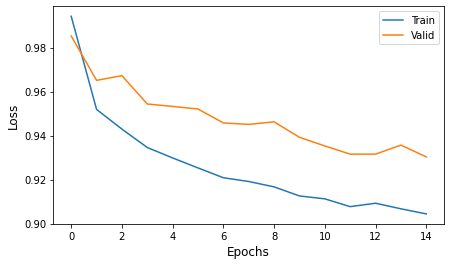

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(np.arange(len(total_loss_train)), total_loss_train, label='Train')
plt.plot(np.arange(len(total_loss_valid)), total_loss_valid, label='Valid')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.show()

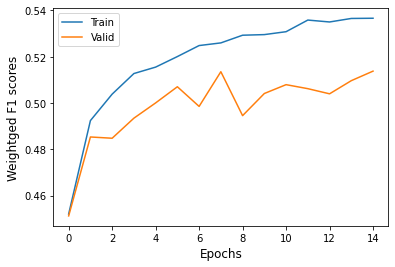

In [ ]:
plt.plot(np.arange(len(train_f1_scores)), train_f1_scores, label='Train')
plt.plot(np.arange(len(valid_f1_scores)), valid_f1_scores, label='Valid')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Weightged F1 scores', fontsize=12)
plt.legend()
plt.show()

In [ ]:
import seaborn as sns

def plot_cm(y_true, y_pred):
  c_matrix = confusion_matrix(y_true, y_pred)
  ax = sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, fmt='.2%', cmap='Blues')

  ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('True Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['Negative','Neutral', 'Positive'])
  ax.yaxis.set_ticklabels(['Negative','Neutral', 'Positive'])

  plt.show()

Validation: 100%|██████████| 96/96 [00:02<00:00, 41.59it/s]



               precision    recall  f1-score   support

           0       0.62      0.05      0.09      3972
           1       0.56      0.74      0.64      5937
           2       0.33      0.56      0.42      2375

    accuracy                           0.48     12284
   macro avg       0.50      0.45      0.38     12284
weighted avg       0.53      0.48      0.42     12284

Confusion matrix
 [[ 204 2491 1277]
 [ 107 4399 1431]
 [  16 1020 1339]] 



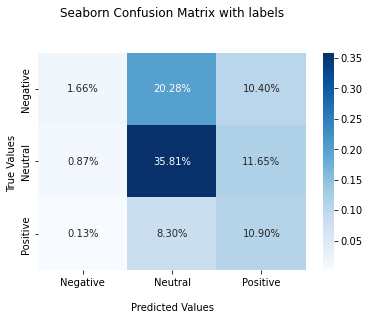

In [ ]:
_, test_f1 = evaluate(model=model, iterator=test_loader, criterion=criterion, testing=True)

# Выводы
Напишите небольшой отчет о проделанной работе. Что удалось, в чем не уверены, что делать дальше.

Был реализован перцептрон. На тренировочных данных наблюдается снижение loss, то есть модель обучалась, что уже хорошо, хотя обучилась она не очень. Лучше всего распознается класс Neutral, который в большом количестве представлен во всех подвыборках.

Я не уверена насчет слоев в модели, возможно, можно подобрать более эффективную их комбинацию. Я пробовала разные варианты с точки зрения их порядка, количества, рассматривала разные функции активации и размеры скрытого слоя. Также для улучшения модели можно было бы попробовать добавить Dropout, early stopping (для отлова переобучения), и получше потьюнить такие параметры, как lr или hidden size.